### **GMV Forecasting with a Weighted Hybrid Model**

#### **Project Overview**

This project demonstrates the development of a robust **GMV (Gross Merchandise Value) forecasting model** for a multi-city business. The primary objective is to predict future GMV with high accuracy by implementing a sophisticated **Weighted Hybrid Model**.

This advanced model leverages the complementary strengths of two powerful time-series forecasting techniques:
1.  **`SARIMAX`**: (Seasonal AutoRegressive Integrated Moving Average with eXogenous factors) for its statistical rigor in capturing complex seasonality.
2.  **Facebook `Prophet`**: For its flexibility in handling holidays, multiple seasonalities, and missing data.

By systematically optimizing the weights of their combined forecasts, the final model achieves superior performance and reliability compared to using either model in isolation.

#### **Business Impact**

Accurate GMV forecasting is a critical driver of strategic business decisions. This model provides actionable insights that can lead to:

*   **Improved Financial Planning**: Enables more reliable revenue projections, leading to smarter budgeting and resource allocation.
*   **Enhanced Marketing Strategy**: Helps in setting realistic sales targets and tailoring marketing campaigns based on anticipated growth in different markets.
*   **Operational Efficiency**: Informs key decisions in inventory management and logistics, ensuring the business can meet projected demand without over-investing.
*   **Proactive Risk Management**: Allows the business to identify potential market-specific downturns, enabling timely and data-driven interventions.

#### **Key Technical Skills & Methodologies**

This project showcases a range of in-demand data science skills:

*   **Forecasting Models**:
    *   Deep implementation of `SARIMAX` and `Prophet`.
    *   Hyperparameter tuning and model diagnostics (`AICc`, residual analysis).

*   **Advanced Techniques**:
    *   **Hybrid Modeling**: Architecting a solution that combines multiple models to improve predictive accuracy and robustness.
    *   **Weight Optimization**: Programmatically finding the optimal weights for the hybrid model by minimizing error metrics (`MAPE`, `MAE`, `RMSE`) on a validation set.

*   **Core Python Libraries**:
    *   **Data Analysis & Manipulation**: `pandas`, `numpy`
    *   **Time-Series Modeling**: `statsmodels`, `prophet`
    *   **Data Visualization**: `matplotlib`
    *   **Model Evaluation**: `scikit-learn`

*   **Data Science Workflow**:
    *   Demonstrated end-to-end project execution from data exploration and preprocessing to model development, evaluation, and visualization.
    *   Writing clean, modular code within a Jupyter Notebook for reproducible and well-documented analysis.

In [ ]:
pip install pmdarima

In [ ]:
pip install scikit-learn==1.4

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error
from pmdarima.arima import auto_arima
import joblib
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

In [4]:
df_weekly_metrics = pd.read_csv('data.csv')
df_weekly_metrics = df_weekly_metrics.fillna(0)

display(df_weekly_metrics)

,week_date,city_name,gmv,x1,x2,x3,x4,x5,x6,x7,...,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18
0,3/6/2023,Hanoi,336461.99,93304.71,27038.76,8173.35,1600,187789,18187,38215,...,251377,11282,8.034042,0.00,0.000,0.00,0,18,0.896591,0.000000
1,3/6/2023,Ho Chi Minh,683597.14,152280.00,39890.25,18334.30,1517,327855,36527,63580,...,408069,21170,6.933629,0.00,0.000,0.00,7,45,0.941689,0.155556
2,3/13/2023,Hanoi,320460.35,89903.14,23255.38,7547.86,3102,137707,18019,77930,...,241324,11401,8.375340,0.00,0.000,0.00,1,22,0.907912,0.045455
3,3/13/2023,Ho Chi Minh,650681.72,147169.71,34773.10,16645.17,3034,250083,34433,127086,...,392669,21414,7.025166,0.00,0.000,0.00,8,50,0.949073,0.160000
4,3/20/2023,Hanoi,319285.58,93309.14,23342.10,7879.92,3012,144195,18531,77982,...,248318,11464,8.455227,0.00,0.000,0.00,7,34,0.908384,0.205882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,6/9/2025,Hanoi,401460.19,121185.29,29806.93,9050.51,4870,179435,28426,93775,...,308144,17472,7.301473,1764.91,1795.170,1825.43,701842,988067,0.901352,0.710318
238,6/16/2025,Hanoi,397784.31,121121.71,28551.75,16545.85,5753,176079,29299,95212,...,306566,17540,7.329792,1775.93,1787.840,1799.75,700838,991094,0.891620,0.707136
239,6/16/2025,Ho Chi Minh,922860.86,249369.00,66183.96,44540.78,11978,419106,55439,215785,...,614331,31865,6.258273,2184.00,2059.150,1934.30,1683803,2442951,0.910727,0.689250
240,6/23/2025,Hanoi,390532.30,119181.57,27853.39,16692.46,4137,178639,29287,90471,...,303708,17552,7.414763,1741.92,1771.250,1800.58,688322,959389,0.913496,0.717459


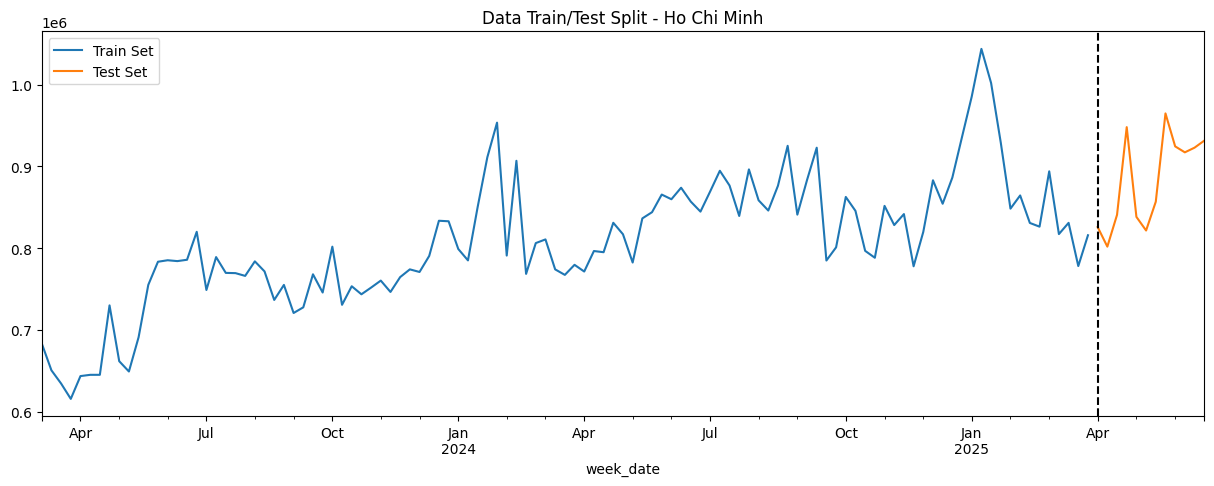

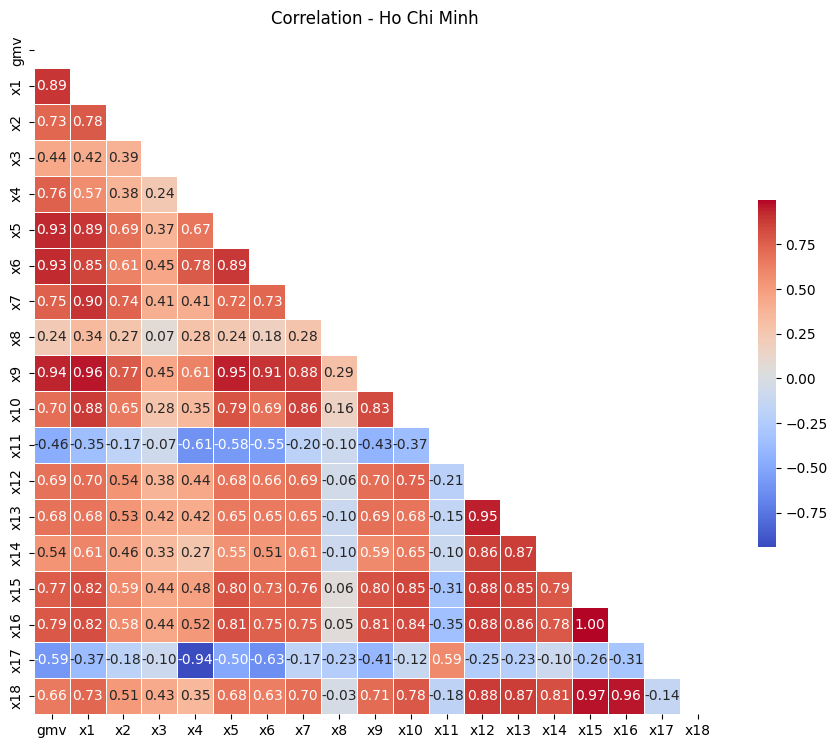

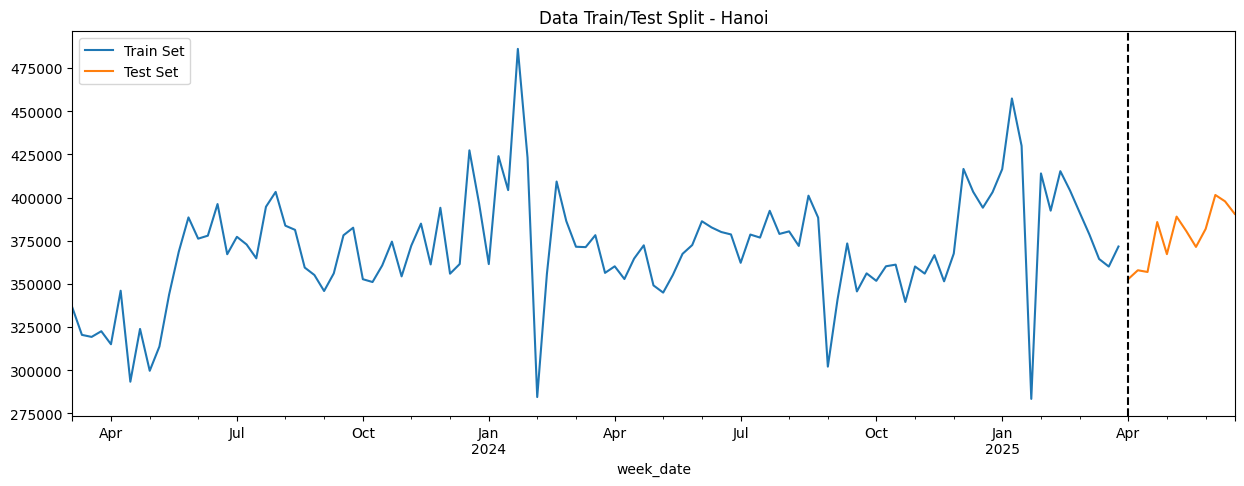

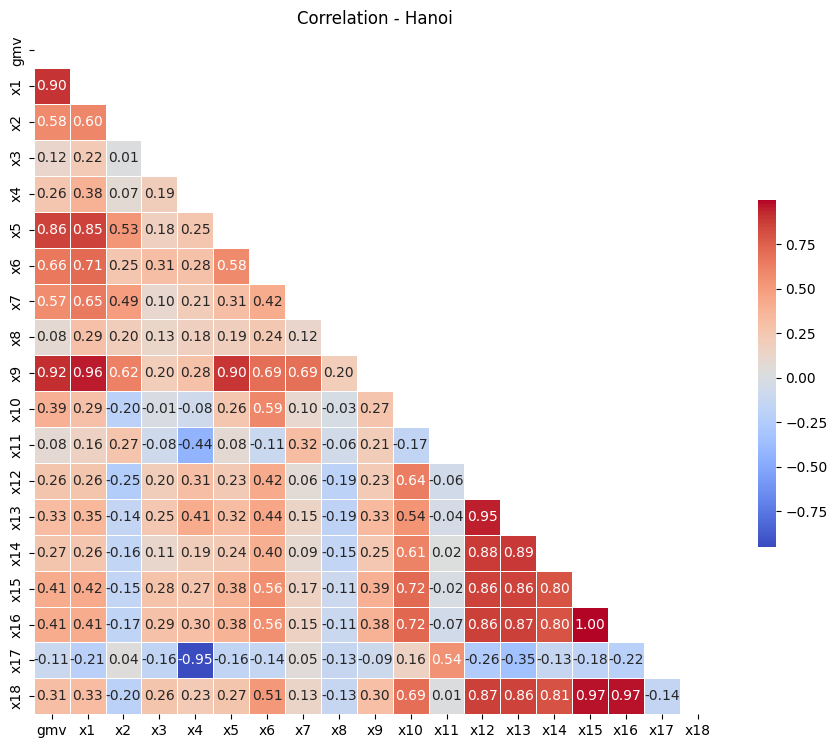

In [5]:
def prepare_train_test_sets(df, city_name_list, date_start_train, date_split):

    train_sets = {}
    test_sets = {}
    for city in city_name_list:
        df_sub = df[df['city_name'] == city]
        train_sets[city] = df_sub[(df_sub.index >= date_start_train) & (df_sub.index < date_split)]
        test_sets[city] = df_sub[(df_sub.index >= date_start_train) & (df_sub.index >= date_split)]
    return train_sets, test_sets

def plot_train_test_split(train_sets, test_sets, city, date_split):

    fig, ax = plt.subplots(figsize=(15, 5))
    train_sets[city]['gmv'].plot(ax=ax, label="Train Set", title=f"Data Train/Test Split - {city}")
    test_sets[city]['gmv'].plot(ax=ax, label="Test Set")
    ax.axvline(date_split, color='black', ls='--')
    ax.legend(["Train Set", "Test Set"])
    plt.show()

def plot_correlation_heatmap(df_sub, city):

    df_corr = df_sub.drop(['city_name'], axis=1)
    corr = df_corr.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    plt.figure(figsize=(11, 9))
    sns.heatmap(
        corr, cmap=cmap, mask=mask, 
        square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
        annot=True, fmt=".2f"
    )
    plt.title(f"Correlation - {city}")
    plt.show()

# --- Main execution ---

date_split = pd.to_datetime("2025-04-01")
date_start_train = pd.to_datetime("2023-03-06")

# Ensure datetime index
df_weekly_metrics['week_date'] = pd.to_datetime(df_weekly_metrics['week_date'])
df_weekly_metrics = df_weekly_metrics.set_index('week_date').sort_index()

city_name_list = ['Ho Chi Minh', 'Hanoi']

train_sets, test_sets = prepare_train_test_sets(df_weekly_metrics, city_name_list, date_start_train, date_split)

for city in city_name_list:
    plot_train_test_split(train_sets, test_sets, city, date_split)
    df_sub = df_weekly_metrics[df_weekly_metrics['city_name'] == city]
    plot_correlation_heatmap(df_sub, city)

### Training

--- Processing: City='Ho Chi Minh' ---
[INFO] New best model found for m=12 | AIC=2425.78

[SUCCESS] Best model for 'Ho Chi Minh' found with m=12 (AICc=2425.78)
Best Model Order: (1, 0, 0), Seasonal Order: (0, 0, 0, 12)


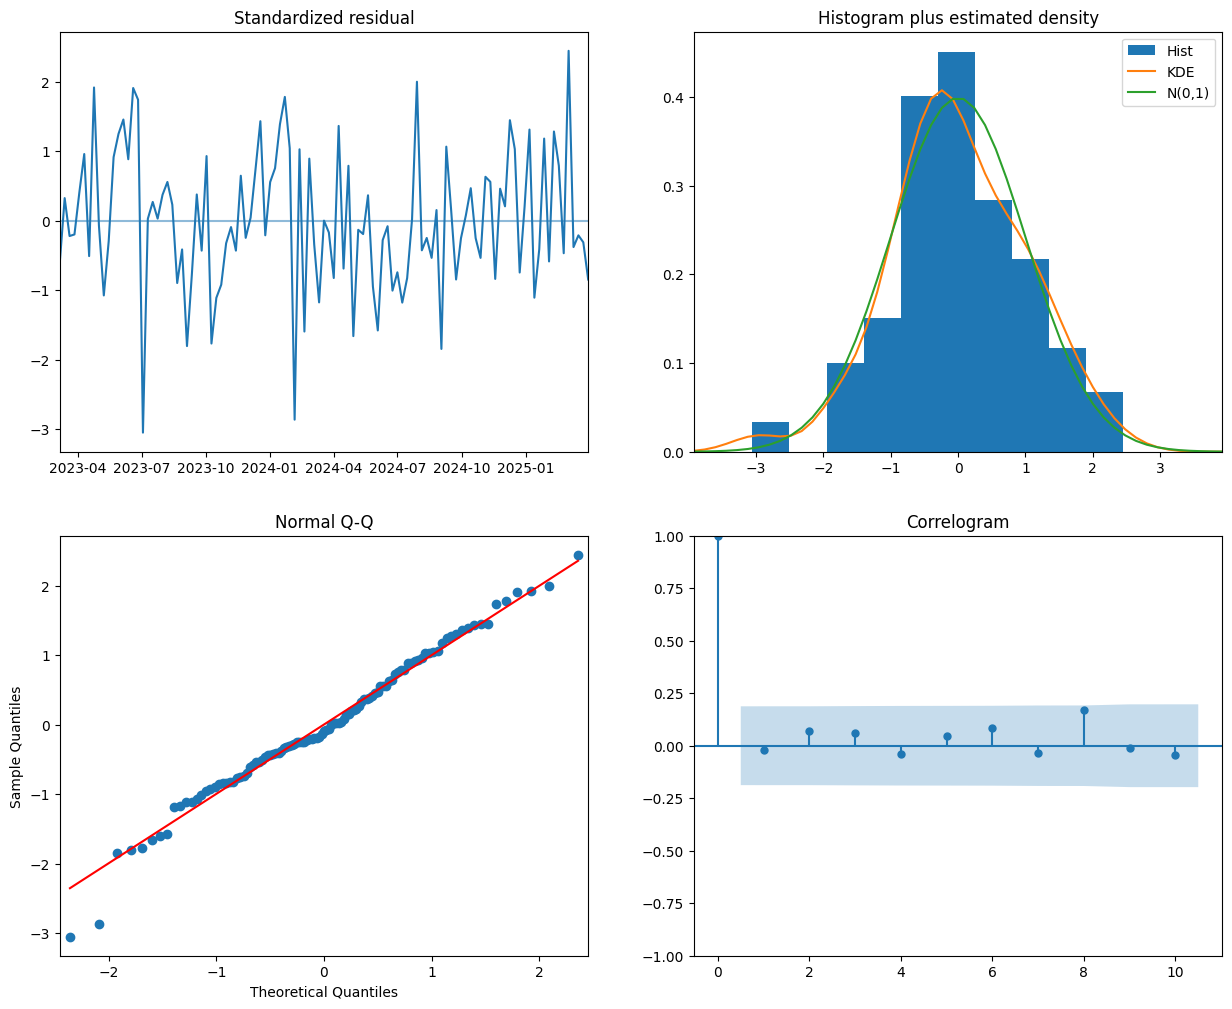

[INFO] Saved model and scaler to: \project\exploration\GMV forecasting model\model\sarimax\SARIMAX_hochiminh.pkl

--- Processing: City='Hanoi' ---
[INFO] New best model found for m=12 | AIC=2287.65

[SUCCESS] Best model for 'Hanoi' found with m=12 (AICc=2287.65)
Best Model Order: (1, 0, 0), Seasonal Order: (0, 0, 0, 12)


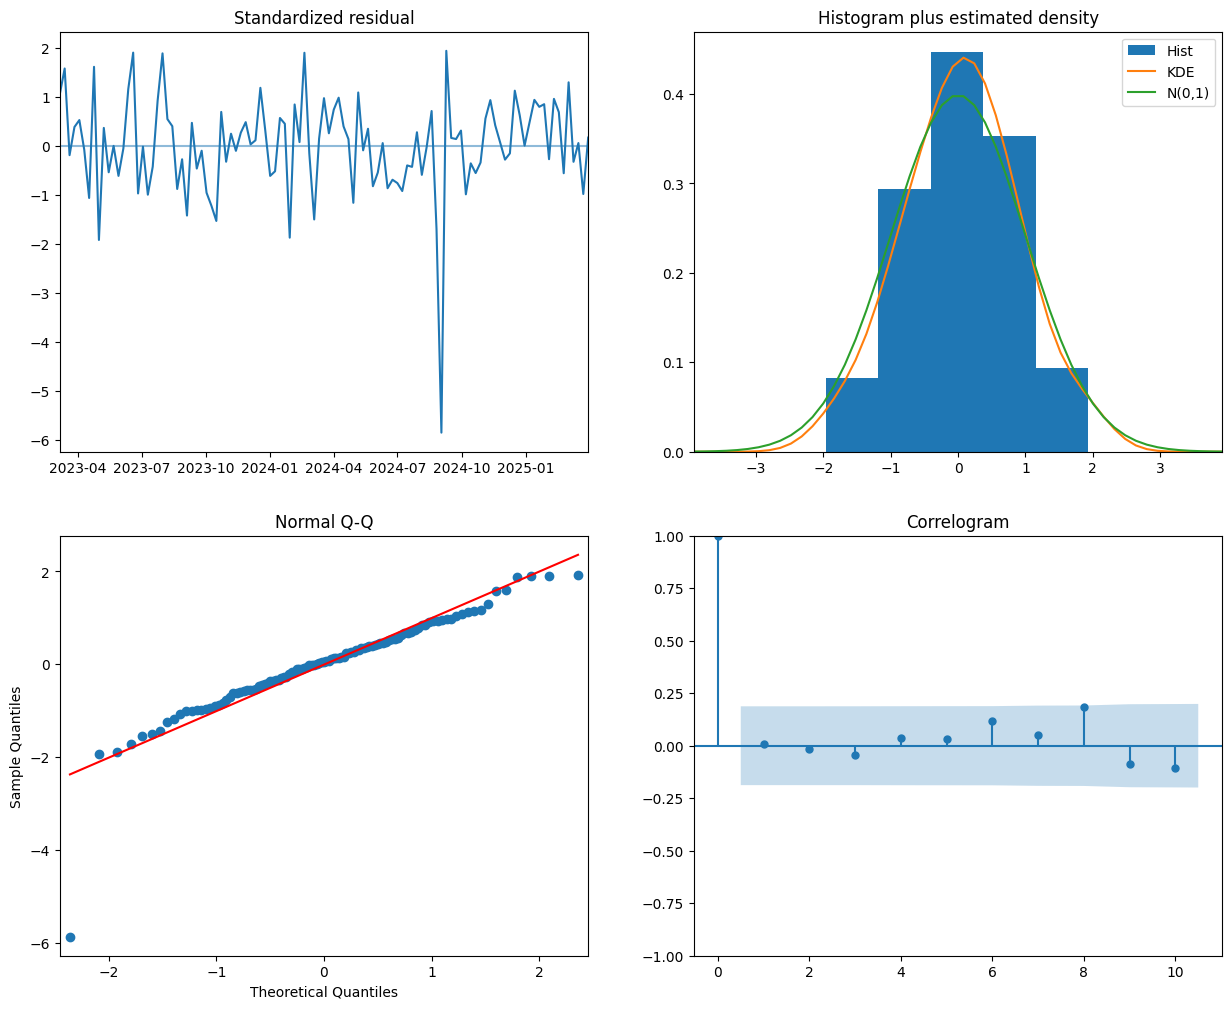

[INFO] Saved model and scaler to: \project\exploration\GMV forecasting model\model\sarimax\SARIMAX_hanoi.pkl



In [ ]:
m_candidates = [12, 26, 52] 

MODEL_OUTPUT_DIR = "\\project\\exploration\\GMV forecasting model\\model\\sarimax"
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

for city in city_name_list:
        print(f"--- Processing: City='{city}' ---")

        try:
            df_train = train_sets[city].copy()
            df_test = test_sets[city].copy()
        except KeyError:
            print(f"[WARN] Data not found for City: {city}. Skipping.")
            continue

        exog_cols = [col for col in df_train.columns if col not in ['city_name', 'gmv']]
        
        X_train = df_train[exog_cols]
        X_test = df_test[exog_cols]
        y_train = df_train['gmv']
        y_test = df_test['gmv']

        scaler = StandardScaler()
        X_scaled_train = scaler.fit_transform(X_train)
        X_scaled_test = scaler.transform(X_test)

        best_model = None
        best_aic = float('inf')
        best_m = None

        for m in m_candidates:
            try:
                model_try = auto_arima(
                    y=y_train, 
                    X=X_scaled_train,
                    seasonal=True, m=m,
                    start_p=1, start_q=1, max_p=5, max_q=5,
                    start_P=0, start_Q=0, max_P=5, max_Q=5,
                    d=None, D=None,
                    stepwise=True,
                    trace=False,
                    suppress_warnings=True, 
                    error_action='ignore',
                    with_intercept='auto',
                    information_criterion='aicc'
                )

                current_aic = model_try.aic()
                if current_aic < best_aic:
                    best_model = model_try
                    best_aic = current_aic
                    best_m = m
                    print(f"[INFO] New best model found for m={m} | AIC={current_aic:.2f}")

            except Exception as e:
                print(f"[WARN] Model fitting failed for m={m} | Error: {e}")

        if best_model:
            print(f"\n[SUCCESS] Best model for '{city}' found with m={best_m} (AICc={best_aic:.2f})")
            print(f"Best Model Order: {best_model.order}, Seasonal Order: {best_model.seasonal_order}")

            best_model.plot_diagnostics(figsize=(15, 12))
            plt.show()

            city_transform = city.lower().replace(" ", "")
            file_basename = f"SARIMAX_{city_transform}"

            artifact_path = os.path.join(MODEL_OUTPUT_DIR, f"{file_basename}.pkl")
            artifacts = {
                'model': best_model,
                'scaler': scaler
            }
            joblib.dump(artifacts, artifact_path)
            print(f"[INFO] Saved model and scaler to: {artifact_path}\n")
            
        else:
            print(f"[ERROR] No valid model could be found for '{city}'.\n")

Loading SARIMAX_hochiminh
Loading SARIMAX_hanoi


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26872\1824066856.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results_sarimax_v7 = pd.concat(all_results_sarimax_v7 + all_results_sarimax_future_v7, ignore_index=True)


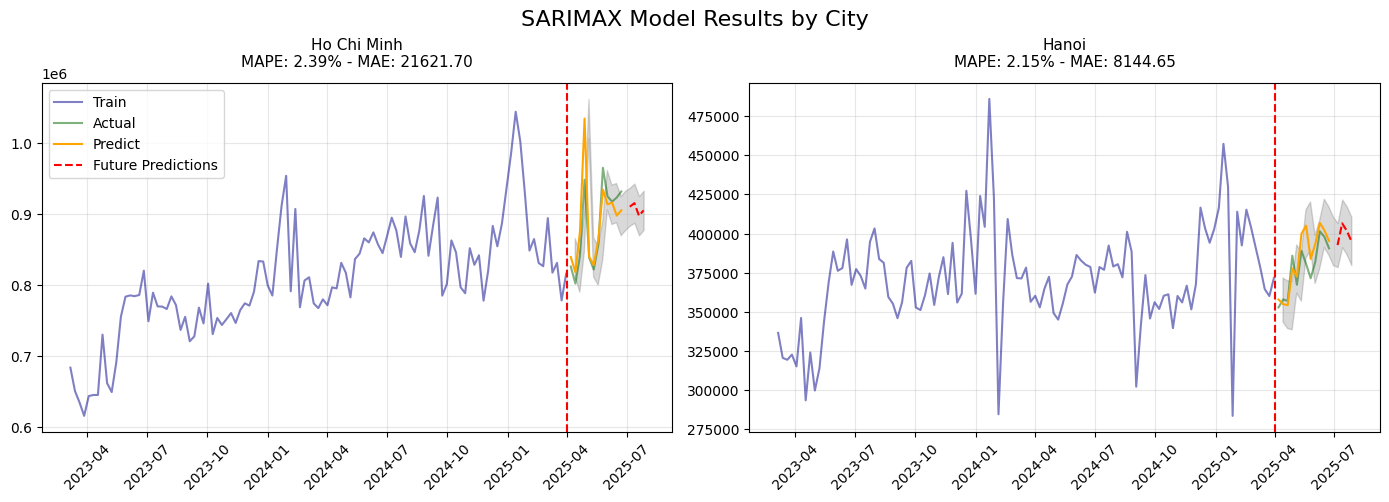

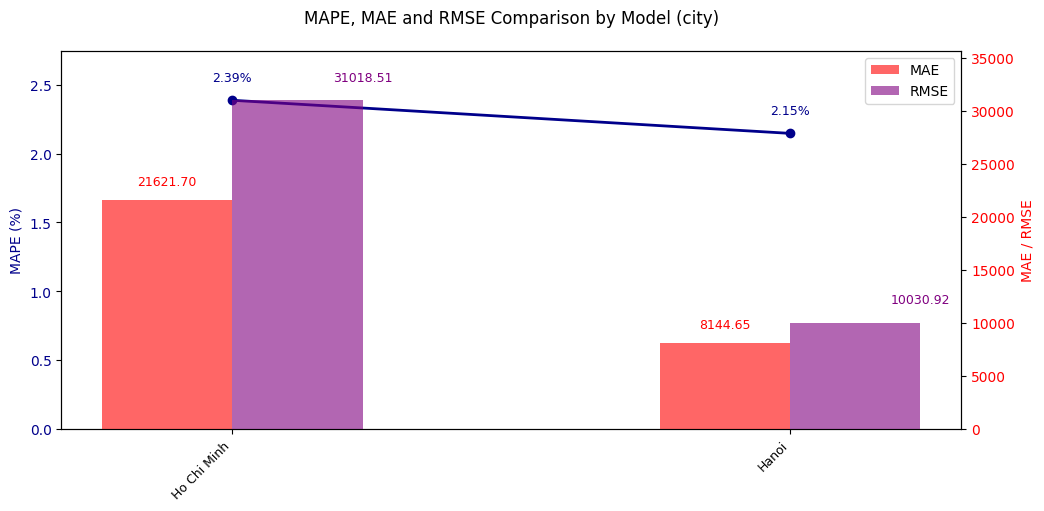

In [ ]:
all_results_sarimax_v7 = []
all_results_sarimax_future_v7 = []
# plot_data = []
mape_data = []
mae_data = []
rmse_data = []

date_split = pd.to_datetime("2025-04-01")

max_date_test_set = pd.to_datetime(df_weekly_metrics.index[-1])
start_period = pd.date_range(start=max_date_test_set + pd.DateOffset(weeks=0), periods=1, freq='W').max()
end_period = pd.date_range(start=max_date_test_set + pd.DateOffset(weeks=0), periods=4, freq='W').max()

# Create a DataFrame for future SARIMAX predictions from start_period to end_period (inclusive)
future_dates = pd.date_range(start=start_period, end=end_period, freq='W')
df_future_sarimax = pd.DataFrame({'week_date': future_dates})
df_future_sarimax['week_date'] = df_future_sarimax['week_date'].dt.date

city_name_list = ['Ho Chi Minh', 'Hanoi']

n_plots = len(city_name_list)
n_cols = __builtins__.min(3, n_plots)
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 5 * n_rows))
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1 or n_cols == 1:
    axes = axes.reshape(-1, 1) if n_cols == 1 else axes.reshape(1, -1)

plot_idx = 0

for city in city_name_list:

        city_transform = city.lower().replace(" ", "")
        print(f"Loading SARIMAX_{city_transform}")

        model_vertical = joblib.load(f"\project\exploration\GMV forecasting model\model\sarimax\SARIMAX_{city_transform}.pkl")
            
        df_train = train_sets[city].copy()
        df_test = test_sets[city].copy()
        X_train = df_train.drop(columns=['city_name', 'gmv'])
        X_test = df_test.drop(columns=['city_name', 'gmv'])
        y_test = df_test['gmv'].reset_index(drop=True)

        scaler = model_vertical['scaler']
        X_test_scaled = scaler.transform(X_test)

        preds, conf_interval = model_vertical['model'].predict(n_periods=len(X_test), X=X_test_scaled, return_conf_int=True)
        index_of_fc = pd.date_range(start=df_test.index[0], periods=len(X_test), freq='W')

        mape = mean_absolute_percentage_error(y_test, preds)
        mape_data.append({'city': city, 'MAPE': mape})

        mae = mean_absolute_error(y_test, preds)
        mae_data.append({'city': city, 'MAE': mae})

        rmse = root_mean_squared_error(y_test, preds)
        rmse_data.append({'city': city, 'RMSE': rmse})

        df_results_v7 = df_test.reset_index()[['week_date', 'city_name']].copy()
        df_results_v7['week_date'] = df_results_v7['week_date'].dt.date
        df_results_v7['preds'] = preds.values
        df_results_v7['gmv'] = y_test.values
        df_results_v7['error'] = df_results_v7['gmv'] - df_results_v7['preds']
        df_results_v7['pct_error'] = df_results_v7['error'] * 100 / df_results_v7['gmv']
        all_results_sarimax_v7.append(df_results_v7)

        # using mean value for future dataframe
        X_future = X_test.tail(4).copy()
        # X_future = pd.concat([X_future.to_frame().T] * 12, ignore_index=True)
        future_X_scaled = scaler.transform(X_future)
        future_preds, conf_interval_future = model_vertical['model'].predict(n_periods=4, X=future_X_scaled, return_conf_int=True)

        index_of_fc_future = pd.date_range(start=df_test.index[-1] + pd.DateOffset(weeks=1), periods=4, freq='W')
        future_dates = pd.date_range(start=df_test.index[-1] + pd.DateOffset(weeks=1), periods=4, freq='W')

        fitted_series = pd.Series(np.concatenate([preds, future_preds]), index=index_of_fc.append(index_of_fc_future))
        lower_series = pd.Series(np.concatenate([conf_interval[:, 0], conf_interval_future[:, 0]]), index=index_of_fc.append(index_of_fc_future))
        upper_series = pd.Series(np.concatenate([conf_interval[:, 1], conf_interval_future[:, 1]]), index=index_of_fc.append(index_of_fc_future))

        # store data for future value
        df_results_future_v7 = df_future_sarimax.copy()
        df_results_future_v7['city_name'] = city
        df_results_future_v7['preds'] = future_preds.values
        df_results_future_v7['gmv'] = None
        df_results_future_v7['error'] = None
        df_results_future_v7['pct_error'] = None
        all_results_sarimax_future_v7.append(df_results_future_v7)


        row = plot_idx // n_cols
        col = plot_idx % n_cols
        ax = axes[row, col]

        ax.plot(df_train.index, df_train['gmv'], label='Train', color='darkblue', alpha=0.5)
        ax.plot(df_test.index, df_test['gmv'], label='Actual', color='darkgreen', alpha=0.5)
        ax.plot(df_test.index, preds, label='Predict', color='orange')
        ax.axvline(date_split, color='red', ls='--')
        ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
        ax.plot(future_dates, future_preds, label='Future Predictions', color='red', linestyle='--')
        ax.set_title(f'{city}\nMAPE: {mape:.2%} - MAE: {mae:.2f}', fontsize=11, pad=12)
        ax.grid(alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        # Only show legend for the first subplot to avoid overlap
        if plot_idx == 0:
            ax.legend(loc='upper left', fontsize=10)
        plot_idx += 1

for idx in range(plot_idx, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row, col])

fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.suptitle('SARIMAX Model Results by City', fontsize=16, y=0.995)

final_results_sarimax_v7 = pd.concat(all_results_sarimax_v7 + all_results_sarimax_future_v7, ignore_index=True)


# convert metrics evaluation to dataframe 
mape_df = pd.DataFrame(mape_data)
mae_df = pd.DataFrame(mae_data)
rmse_data = pd.DataFrame(rmse_data)

# Create performance comparison bar plot in a new figure
fig2, ax1 = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(bottom=0.25, left=0.1, right=0.85)

x_labels = mape_df['city']
x = np.arange(len(x_labels))
width = 0.35

# Plot MAPE as a line
ax1.plot(x, mape_df['MAPE'] * 100, marker='o', label='MAPE (%)', color='darkblue', linewidth=2)
ax1.set_ylabel('MAPE (%)', color='darkblue', fontsize=10)
ax1.tick_params(axis='y', labelcolor='darkblue')

# Add MAPE values above points
for i, mape in enumerate(mape_df['MAPE']):
    ax1.text(
        x[i],
        mape * 100 + (mape_df['MAPE'].max() * 100 * 0.05),
        f'{mape:.2%}',
        ha='center',
        va='bottom',
        fontsize=9,
        color='darkblue'
    )

# Plot MAE and RMSE on the same chart with a secondary y-axis
ax2 = ax1.twinx()
bar_width = width / 1.5

mae_bars = ax2.bar(x - bar_width/2, mae_df['MAE'], bar_width, color='red', alpha=0.6, label='MAE')
rmse_bars = ax2.bar(x + bar_width/2, rmse_data['RMSE'], bar_width, color='purple', alpha=0.6, label='RMSE')

ax2.set_ylabel('MAE / RMSE', color='red', fontsize=10)
ax2.tick_params(axis='y', labelcolor='red')

# Add MAE values on top of bars
for i, bar in enumerate(mae_bars):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        height + (mae_df['MAE'].max() * 0.05),
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=9,
        color='red'
    )

# Add RMSE values on top of bars
for i, bar in enumerate(rmse_bars):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width(),
        height + (rmse_data['RMSE'].max() * 0.05),
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=9,
        color='purple'
    )

ax2.legend(loc='upper right', fontsize=10)

plt.title('MAPE, MAE and RMSE Comparison by Model (city)', pad=20, fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)

ax1.set_ylim(0, mape_df['MAPE'].max() * 100 * 1.15)
ax2.set_ylim(0, rmse_data['RMSE'].max() * 1.15)
plt.show()

In [ ]:
# def compare_scenarios(model_vertical, train_data, test_data, simulate_date, scenarios):
#     print(f"\n🔄 SCENARIO COMPARISON for {simulate_date}")
#     print("=" * 60)
    
#     results = {}
    
#     for scenario_name, changes in scenarios.items():

#         X_train = train_data.drop(columns=['city_name', 'gmv'])
#         X_test = test_data.drop(columns=['city_name', 'gmv'])
        
#         scaler = StandardScaler()
#         scaler.fit(X_train)
        
#         # Find target row
#         test_data_reset = test_data.reset_index()
#         row_idx = test_data_reset[test_data_reset['week_date'].astype(str) == simulate_date].index[0]
        
#         # Apply scenario changes
#         X_test_scenario = X_test.copy()
#         for feature, value in changes.items():
#             if feature in X_test_scenario.columns:
#                 X_test_scenario.iloc[row_idx, X_test_scenario.columns.get_loc(feature)] = value

#         # Ensure all columns are numeric before scaling
#         X_test_scenario = X_test_scenario.apply(pd.to_numeric, errors='coerce')
        
#         # Align the number of features with the scaler
#         X_test_scenario = X_test_scenario[X_train.columns]
        
#         X_test_scaled = scaler.transform(X_test_scenario)
#         steps_ahead = row_idx + 1
#         predictions = model_vertical['model'].predict(n_periods=int(steps_ahead), X=X_test_scaled[:steps_ahead])
        
#         predictions = predictions.reset_index(drop=True)
#         results[scenario_name] = {
#             'prediction': predictions[row_idx],
#             'changes': changes
#         }
        
#         print(f"📊 {scenario_name}:")
#         for feature, value in changes.items():
#             print(f"   {feature}: ${value if isinstance(value, (int, float)) else value.values[0]:,.0f}")
#         print(f"   Predicted GMV: ${predictions[row_idx]:,.2f}")
#         print()
    
#     # Show comparison
#     baseline_pred = list(results.values())[0]['prediction']
#     print("📈 Impact Analysis:")
#     for scenario_name, result in results.items():
#         impact = result['prediction'] - baseline_pred
#         print(f"   {scenario_name}: {impact:+,.2f} vs baseline ({impact/baseline_pred*100:+.1f}%)")
    
#     return results


# for city in city_name_list:

#     city_transform = city.lower().replace(" ", "")
#     print(f"Loading SARIMAX_{city_transform}")
    
#     model_vertical = joblib.load(f"/project/exploration/GMV forecasting model/model/sarimax/SARIMAX_{city_transform}.pkl")
        

#     df_train = train_sets[city].copy()
#     df_test = test_sets[city].copy()

#     simulate_date = '2025-06-09'
#     df_simulate_promo = df_test[df_test.index.astype(str) == simulate_date]['x2']
#     scenarios = {
#         'Current': {'x2': df_simulate_promo},
#         'Scenario A (x1.5)': {'x2': df_simulate_promo*1.5},
#         'Scenario B (x1.8)': {'x2': df_simulate_promo*1.8},
#         'Scenario C (x2)': {'x2': df_simulate_promo*2}
#     }

#     print(f'Model: {city}')
#     results = compare_scenarios(model_vertical, df_train, df_test, simulate_date, scenarios)

Loading SARIMAX_hochiminh
Model: Ho Chi Minh

🔄 SCENARIO COMPARISON for 2025-06-09
📊 Current:
   x2: $64,581
   Predicted GMV: $915,823.67

📊 Scenario A (x1.5):
   x2: $96,872
   Predicted GMV: $940,370.67

📊 Scenario B (x1.8):
   x2: $116,247
   Predicted GMV: $955,098.87

📊 Scenario C (x2):
   x2: $129,163
   Predicted GMV: $964,917.67

📈 Impact Analysis:
   Current: +0.00 vs baseline (+0.0%)
   Scenario A (x1.5): +24,547.00 vs baseline (+2.7%)
   Scenario B (x1.8): +39,275.20 vs baseline (+4.3%)
   Scenario C (x2): +49,094.00 vs baseline (+5.4%)
Loading SARIMAX_hanoi
Model: Hanoi

🔄 SCENARIO COMPARISON for 2025-06-09
📊 Current:
   x2: $29,807
   Predicted GMV: $406,785.82

📊 Scenario A (x1.5):
   x2: $44,710
   Predicted GMV: $421,545.34

📊 Scenario B (x1.8):
   x2: $53,652
   Predicted GMV: $430,401.06

📊 Scenario C (x2):
   x2: $59,614
   Predicted GMV: $436,304.87

📈 Impact Analysis:
   Current: +0.00 vs baseline (+0.0%)
   Scenario A (x1.5): +14,759.53 vs baseline (+3.6%)
   Sce

## Prophet

In [ ]:
pip install prophet

In [ ]:
def train_prophet_model(df_train, df_test, list_features):

    model = Prophet(    
        # yearly_seasonality=True,
        # weekly_seasonality=True,
        # daily_seasonality=False,
        seasonality_mode='multiplicative',
        interval_width=0.95
    )
    for regressor in list_features:
        model.add_regressor(regressor, mode='multiplicative')
    
    # Add country-specific holidays if needed
    model.add_country_holidays(country_name='VN')

    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=5)
    model.add_seasonality(name='yearly', period=365.25, fourier_order=5)
    
    # Fit the model
    model.fit(df_train)
    
    # Make predictions for test set
    # future_dates = df_test.copy()
    forecast = model.predict(df_test)
    
    # Calculate metrics
    y_true = df_test['y'].values
    y_pred = forecast['yhat'].values
    
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return model, forecast, mape, rmse, mae


Processing Ho Chi Minh


21:54:08 - cmdstanpy - INFO - Chain [1] start processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing


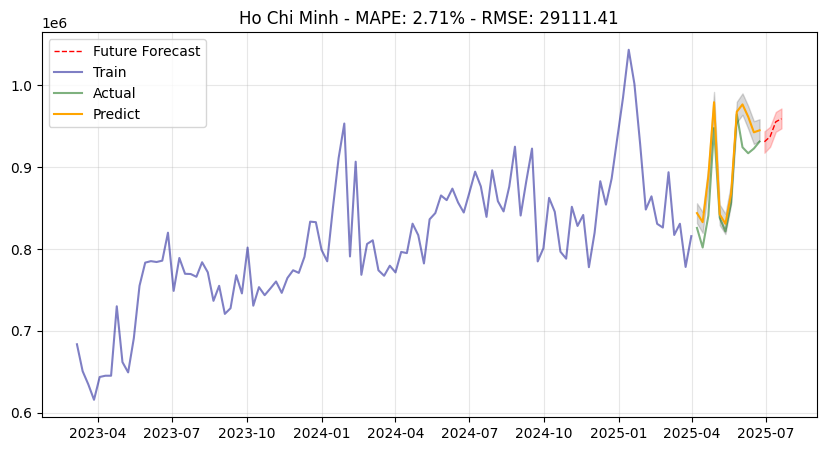

21:54:09 - cmdstanpy - INFO - Chain [1] start processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing



Processing Hanoi


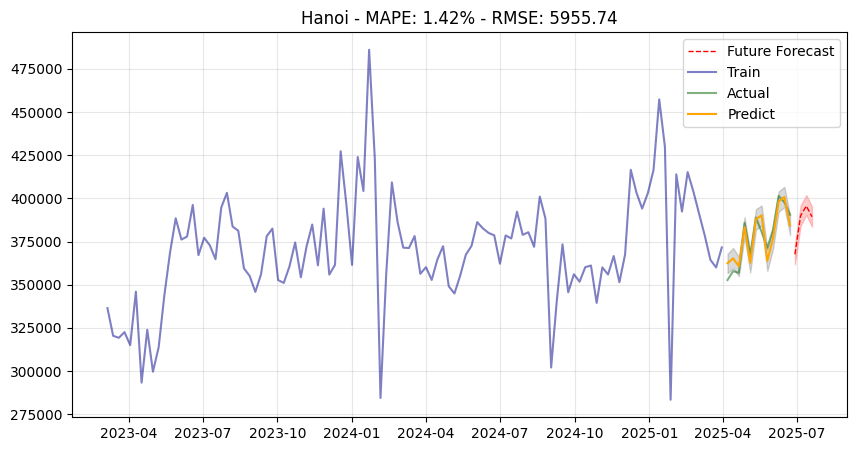

In [ ]:
# Split data into train and test sets
results = {}
results_future_prophet = {}

# Process TPT verticals (2W and 4W)
for city in city_name_list:
    print(f"\nProcessing {city}")

    df_train = train_sets[city].copy()
    df_test = test_sets[city].copy()

    df_train = df_train.reset_index()
    df_train = df_train.drop(columns=['city_name'])
    df_train = df_train.rename(columns={'week_date': 'ds', 'gmv': 'y'})

    df_test = df_test.reset_index()
    df_test = df_test.drop(columns=['city_name'])
    df_test = df_test.rename(columns={'week_date': 'ds', 'gmv': 'y'})

    list_features = df_train.drop(columns=['ds', 'y'])
    list_features = list_features.columns.tolist()

    # Train model and get predictions
    model, forecast, mape, rmse, mae = train_prophet_model(df_train, df_test, list_features)
    
    # Store results
    results[city] = {
        'model': model,
        'forecast': forecast,
        'mape': mape,
        'rmse': rmse,
        'mae': mae,
        'train_data': df_train,
        'test_data': df_test
    }

    ## for future forecast
    last_4_weeks = df_test.tail(4).sort_values(by='ds')

    future_df = df_future_sarimax.rename(columns={'week_date': 'ds'}).reset_index(drop=True).sort_values(by='ds')
    last_4_features = last_4_weeks.drop(columns=['ds']).reset_index(drop=True)

    for col in last_4_features.columns:
        future_df[col] = last_4_features[col]
    
    future_forecast = model.predict(future_df)


    # Store future results
    results_future_prophet[city] = {
        'forecast': future_forecast,
        'future_date': future_df
    }
    
    # Plot results
    plt.figure(figsize=(10, 5))

    # Plot future predictions
    plt.plot(pd.to_datetime(future_df['ds']), future_forecast['yhat'],
            label='Future Forecast', color='red', linewidth=1, linestyle='--')
    
    # Plot future confidence intervals  
    plt.fill_between(pd.to_datetime(future_df['ds']),
                    future_forecast['yhat_lower'],
                    future_forecast['yhat_upper'],
                    color='red', alpha=0.2)

    
    plt.plot( df_train['ds'], df_train['y'], label='Train', color='darkblue', alpha=0.5)
    plt.plot(df_test['ds'], df_test['y'], label='Actual', color='darkgreen', alpha=0.5)
    plt.plot(df_test['ds'], forecast.yhat, label='Predict', color='orange')
    # plt.axvline(date_split, color='red', ls='--')
    plt.fill_between(forecast['ds'], 
                forecast.yhat_lower, 
                forecast.yhat_upper, 
                color='k', alpha=.15)

    plt.title(f'{city} - MAPE: {mape:.2%} - RMSE: {rmse:.2f}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [36]:
# error_matrix = {}
optimal_weights = {}
result_optimization = {}

max_test_set = results[city]['test_data']['ds'].max()

for city in city_name_list:

    # Calculate logarithmic errors as per the paper (e_it = log(actual) - log(predicted))
    e_prophet = np.log(results[city]['test_data']['y'].values) - np.log(results[city]['forecast']['yhat'].values)
    e_sarimax = np.log(results[city]['test_data']['y'].values) - np.log(final_results_sarimax_v7[(final_results_sarimax_v7['week_date'] <= max_test_set.date()) & (final_results_sarimax_v7['city_name'] == city)]['preds'].values)

    error_matrix = np.vstack([e_sarimax, e_prophet]).T # Shape: (N_val, 2)


    def objective_function(weights):
        """The function to minimize, as per formula (6) in the paper. """
        weighted_errors = np.dot(error_matrix, weights)
        return np.sum(np.abs(weighted_errors))

    # Initial guess for weights
    initial_weights = [0.5, 0.5]

    # Constraints: weights sum to 1 and are non-negative
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1), (0, 1)]

    # Run the optimization
    result_optimization = minimize(
        objective_function,
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    optimal_weights[city] = result_optimization.x
    print(f"Optimal Weights -> {city}:\n  \tSARIMAX: {optimal_weights[city][0]:.4f}, Prophet: {optimal_weights[city][1]:.4f}")

# optimal_weights

Optimal Weights -> Ho Chi Minh:
  	SARIMAX: 0.4332, Prophet: 0.5668
Optimal Weights -> Hanoi:
  	SARIMAX: 0.3863, Prophet: 0.6137


In [ ]:
# #for what-if scenario
# simulate_date = '2025-06-09'

# all_results_scenario_future_v7 = []

# for city in city_name_list:

#     model_vertical = joblib.load(f"/project/exploration/GMV forecasting model/model/sarimax/SARIMAX_{city_transform}.pkl")

#     df_train = train_sets[city].copy()
#     df_test = test_sets[city].copy()

#     df_simulate_promo = df_test[df_test.index.astype(str) == simulate_date]['x2']
#     scenarios = {
#         # 'Current': {'x2': df_simulate_promo},
#         'Scenario A (x1.5)': {'x2': df_simulate_promo*1.5},
#         'Scenario B (-x1.5)': {'x2': df_simulate_promo*0.5},
#         'Scenario C (x1)': {'x2': df_simulate_promo*1}
#         }

#     X_train = df_train.drop(columns=['city_name', 'gmv'])
#     X_test = df_test.drop(columns=['city_name', 'gmv'])
        
#     scaler = model_vertical['scaler']

#     for scenario_name, changes in scenarios.items():
        
#         # Apply scenario changes
#         X_test_scenario = X_test.tail(4).copy()
#         for feature, value in changes.items():
#             if feature in X_test_scenario.columns:
#                 for i in range(len(X_test_scenario)):
#                     X_test_scenario.iloc[i, X_test_scenario.columns.get_loc(feature)] = value
                
#                 X_test_scaled = scaler.transform(X_test_scenario)
#                 predictions = model_vertical['model'].predict(n_periods=4, X=X_test_scaled)
                
#                 df_results_future_scenario_v7 = df_future_sarimax.sort_values(by='week_date').copy()
#                 df_results_future_scenario_v7['scenario_name'] = scenario_name
#                 df_results_future_scenario_v7['city_name'] = city
#                 df_results_future_scenario_v7['preds'] = predictions.values
#                 df_results_future_scenario_v7['gmv'] = None
#                 df_results_future_scenario_v7['error'] = None
#                 df_results_future_scenario_v7['pct_error'] = None
#         all_results_scenario_future_v7.append(df_results_future_scenario_v7)
# all_results_scenario_future_v7 = pd.concat(all_results_scenario_future_v7, ignore_index=True)
# display(all_results_scenario_future_v7)

,week_date,scenario_name,city_name,preds,gmv,error,pct_error
0,2025-06-29,Scenario A (x1.5),Ho Chi Minh,738567.391455,None,None,None
1,2025-07-06,Scenario A (x1.5),Ho Chi Minh,717466.310187,None,None,None
2,2025-07-13,Scenario A (x1.5),Ho Chi Minh,716201.557751,None,None,None
3,2025-07-20,Scenario A (x1.5),Ho Chi Minh,726477.704258,None,None,None
4,2025-06-29,Scenario B (-x1.5),Ho Chi Minh,674609.715581,None,None,None
5,2025-07-06,Scenario B (-x1.5),Ho Chi Minh,653508.634313,None,None,None
6,2025-07-13,Scenario B (-x1.5),Ho Chi Minh,652243.881877,None,None,None
7,2025-07-20,Scenario B (-x1.5),Ho Chi Minh,662520.028384,None,None,None
8,2025-06-29,Scenario C (x1),Ho Chi Minh,706588.553518,None,None,None
9,2025-07-06,Scenario C (x1),Ho Chi Minh,685487.472250,None,None,None



--- Plotting Results ---


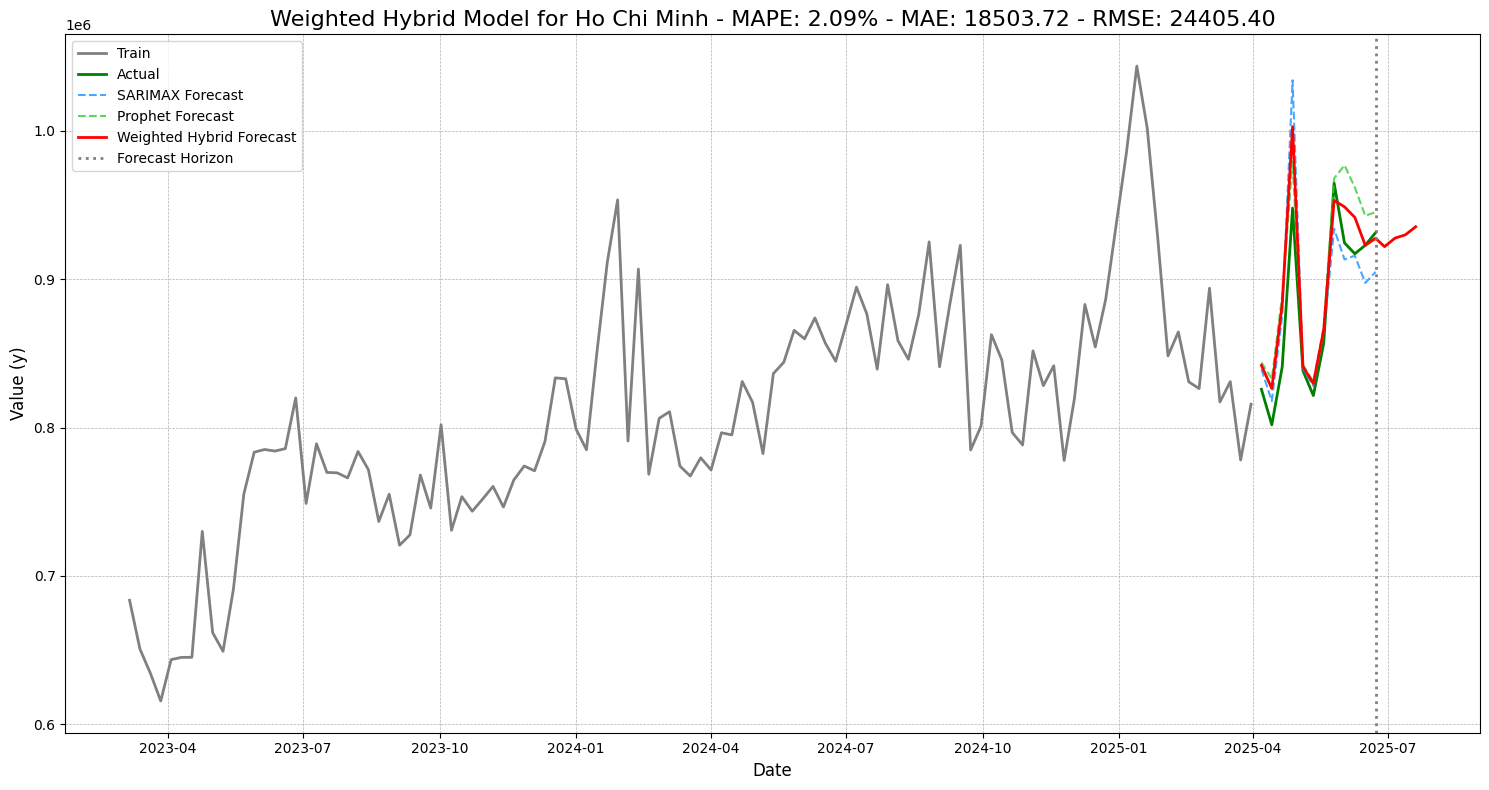


--- Plotting Results ---


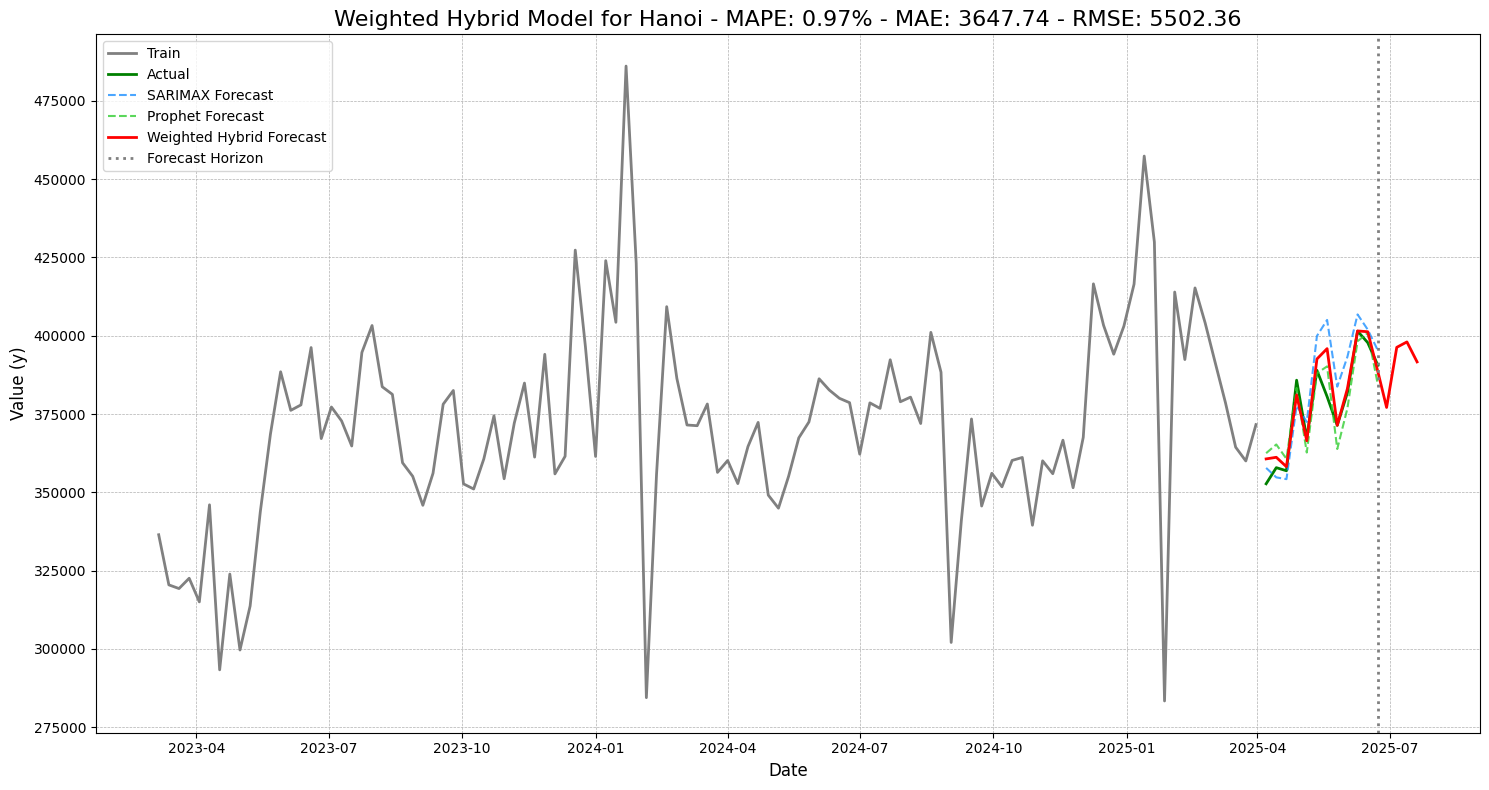

In [58]:
val_results = []
future_results = []
scenario_results = []

for city in city_name_list:

    max_test_set = results[city]['test_data']['ds'].max()

    # on test set
    # log(hybrid) = w1*log(sarimax) + w2*log(prophet) => hybrid = exp(...)
    log_prophet = np.log(results[city]['forecast']['yhat'].values)
    log_sarimax = np.log(
    final_results_sarimax_v7[
        (final_results_sarimax_v7['city_name'] == city) &
        (pd.to_datetime(final_results_sarimax_v7['week_date']) <= pd.to_datetime(max_test_set))
    ]['preds'].values
    )
    log_hybrid = optimal_weights[city][0] * log_sarimax + optimal_weights[city][1] * log_prophet
    hybrid_forecast = np.exp(log_hybrid)

    # result_df on test set
    results_df = pd.DataFrame({
        'city': city,
        'ds': results[city]['test_data']['ds'],
        'gmv': results[city]['test_data']['y'].values,
        'SARIMAX': final_results_sarimax_v7[(final_results_sarimax_v7['city_name'] == city) & (pd.to_datetime(final_results_sarimax_v7['week_date']) <= pd.to_datetime(max_test_set))]['preds'].values,
        'Prophet': results[city]['forecast']['yhat'].values,
        'Weighted Hybrid Model': hybrid_forecast
    })
    val_results.append(results_df)
    

    metrics = {}

    for model_name in ['SARIMAX', 'Prophet', 'Weighted Hybrid Model']:
        y_pred = results_df[model_name]
        y_true = results[city]['test_data']['y'].values
        
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred)
        
        metrics[model_name] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}


    # on future date
    
    # log(hybrid) = w1*log(sarimax) + w2*log(prophet) => hybrid = exp(...)
    log_future_prophet = np.log(results_future_prophet[city]['forecast']['yhat'].values)

    final_results_sarimax_v7_sort = final_results_sarimax_v7[(final_results_sarimax_v7['city_name'] == city) & (pd.to_datetime(final_results_sarimax_v7['week_date']) > pd.to_datetime(max_test_set))].sort_values(by='week_date')
    log_future_sarimax = np.log(final_results_sarimax_v7_sort['preds'].values)
    log_future_hybrid = optimal_weights[city][0] * log_future_sarimax + optimal_weights[city][1] * log_future_prophet
    hybrid_future_forecast = np.exp(log_future_hybrid)

    # result_df on test set
    results_future_df = pd.DataFrame({
        'city': city,
        'ds': results_future_prophet[city]['future_date']['ds'],
        'SARIMAX': final_results_sarimax_v7[(final_results_sarimax_v7['city_name'] == city) & (pd.to_datetime(final_results_sarimax_v7['week_date']) > pd.to_datetime(max_test_set))]['preds'].values,
        'Prophet': results_future_prophet[city]['forecast']['yhat'].values,
        'Weighted Hybrid Model': hybrid_future_forecast
    })
    future_results.append(results_future_df)


    # on scenario
    # for scenario_name in all_results_scenario_future_v7['scenario_name'].unique():

    #     # log(hybrid) = w1*log(sarimax) + w2*log(prophet) => hybrid = exp(...)
    #     log_future_prophet = np.log(results_future_prophet[city]['forecast']['yhat'].values)

    #     all_results_scenario_future_v7_sort = all_results_scenario_future_v7[(all_results_scenario_future_v7['scenario_name'] == scenario_name) & (all_results_scenario_future_v7['city_name'] == city) & (pd.to_datetime(all_results_scenario_future_v7['week_date']) > pd.to_datetime(max_test_set))].sort_values(by='week_date')
    #     log_future_sarimax = np.log(all_results_scenario_future_v7_sort['preds'].values)
    #     if optimal_weights[city][0] < 0.2:

    #         base_sarimax = final_results_sarimax_v7[(final_results_sarimax_v7['city_name'] == city) & (pd.to_datetime(final_results_sarimax_v7['week_date']) > pd.to_datetime(max_test_set))].sort_values(by='week_date')

    #         scenario_sarimax = all_results_scenario_future_v7[(all_results_scenario_future_v7['scenario_name'] == scenario_name) & (all_results_scenario_future_v7['city_name'] == city) & (pd.to_datetime(all_results_scenario_future_v7['week_date']) > pd.to_datetime(max_test_set))].sort_values(by='week_date')

    #         gap = np.abs(base_sarimax.reset_index(drop=True)['preds'] - scenario_sarimax.reset_index(drop=True)['preds'])

    #         log_future_hybrid = optimal_weights[city][0] * log_future_sarimax + optimal_weights[city][1] * log_future_prophet
    #         hybrid_future_forecast = np.exp(log_future_hybrid) + gap
    #     else:
    #         log_future_hybrid = optimal_weights[city][0] * log_future_sarimax + optimal_weights[city][1] * log_future_prophet
    #         hybrid_future_forecast = np.exp(log_future_hybrid)

    #     # result_df on test set
    #     results_future_scenario_df = pd.DataFrame({
    #         'scenario_name': scenario_name,
    #         'city': city,
    #         'ds': results_future_prophet[city]['future_date']['ds'],
    #         'SARIMAX': all_results_scenario_future_v7[(all_results_scenario_future_v7['scenario_name'] == scenario_name) & (all_results_scenario_future_v7['city_name'] == city) & (pd.to_datetime(all_results_scenario_future_v7['week_date']) > pd.to_datetime(max_test_set))]['preds'].values,
    #         'Prophet': results_future_prophet[city]['forecast']['yhat'].values,
    #         'Weighted Hybrid Model': hybrid_future_forecast
    #     })
    #     scenario_results.append(results_future_scenario_df)


    # --- PLOTTING PHASE ---
    print("\n--- Plotting Results ---")

    # plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot historical data
    ax.plot(results[city]['train_data']['ds'], results[city]['train_data']['y'], color='grey', linewidth=2, label='Train')
    ax.plot(results[city]['test_data']['ds'], results[city]['test_data']['y'], color='green', linewidth=2, label='Actual')

    # Plot the individual forecasts
    ax.plot(results_df['ds'], results_df['SARIMAX'], color='dodgerblue', linestyle='--', alpha=0.8, label='SARIMAX Forecast')
    ax.plot(results_df['ds'], results_df['Prophet'], color='limegreen', linestyle='--', alpha=0.8, label='Prophet Forecast')

    # Plot the final hybrid forecast

    results_future_df['gmv'] = float(0.0)
    results_df['ds'] = results_df['ds'].dt.date

    df_merge_results = pd.concat([results_df, results_future_df], axis=0, ignore_index=True).sort_values(by='ds')

    ax.plot(df_merge_results['ds'], df_merge_results['Weighted Hybrid Model'], color='red', linewidth=2, label='Weighted Hybrid Forecast')

    # Plot the final hybrid forecast - scenarios
    # ax.plot(scenario_results[0]['ds'].sort_values(), scenario_results[0]['Weighted Hybrid Model'], color='blue', linewidth=2, label=scenario_results[0]['scenario_name'][0])
    # ax.plot(scenario_results[1]['ds'].sort_values(), scenario_results[1]['Weighted Hybrid Model'], color='blue', linewidth=2, label=scenario_results[1]['scenario_name'][0])

    forecast_start_date = results_df['ds'].max()
    ax.axvline(x=forecast_start_date, color='grey', linestyle=':', linewidth=2, label='Forecast Horizon')


    # Formatting
    # ax.set_title(f'Comparison of Forecast Models for {vertical} in {city}', fontsize=16)
    ax.set_title(f'Weighted Hybrid Model for {city} - MAPE: {mape:.2%} - MAE: {mae:.2f} - RMSE: {rmse:.2f}', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Value (y)', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

all_val_results_df = pd.concat(val_results, ignore_index=True)
all_future_results_df = pd.concat(future_results, ignore_index=True)
# all_future_scenario_results_df = pd.concat(scenario_results, ignore_index=True)

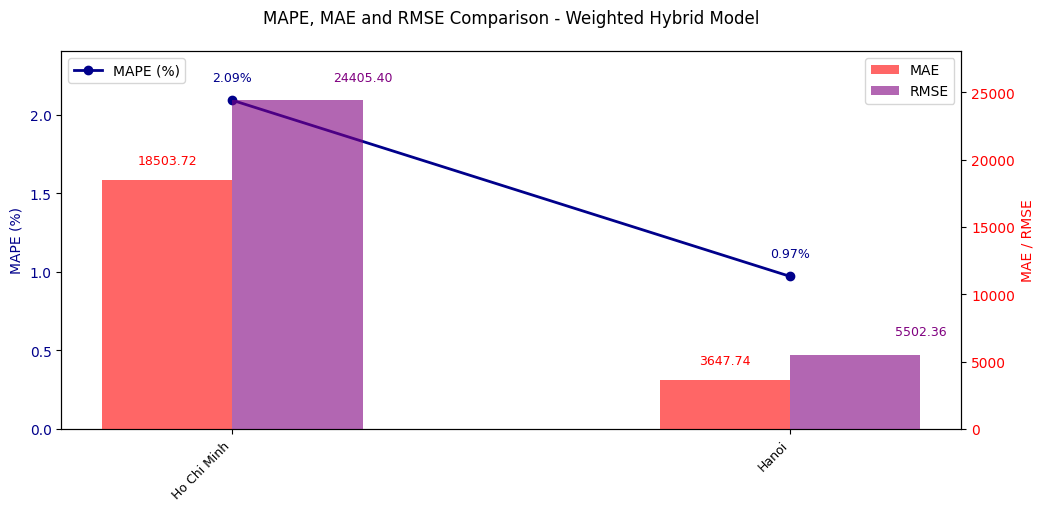

In [72]:
df_metrics = pd.DataFrame(metrics)
df_metrics_hybrid = df_metrics[df_metrics['model'] == 'Weighted Hybrid Model']

# Create performance comparison bar plot in a new figure
fig2, ax1 = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(bottom=0.25, left=0.1, right=0.85)

x_labels = df_metrics_hybrid['city']
x = np.arange(len(x_labels))
width = 0.35

# Plot MAPE as a line
ax1.plot(x, df_metrics_hybrid['MAPE'] * 100, marker='o', label='MAPE (%)', color='darkblue', linewidth=2)
ax1.set_ylabel('MAPE (%)', color='darkblue', fontsize=10)
ax1.tick_params(axis='y', labelcolor='darkblue')

# Add MAPE values above points
for i, mape in enumerate(df_metrics_hybrid['MAPE']):
    ax1.text(
        x[i],
        mape * 100 + (df_metrics_hybrid['MAPE'].max() * 100 * 0.05),
        f'{mape:.2%}',
        ha='center',
        va='bottom',
        fontsize=9,
        color='darkblue'
    )

# Plot MAE and RMSE on the same chart with a secondary y-axis
ax2 = ax1.twinx()
bar_width = width / 1.5

mae_bars = ax2.bar(x - bar_width/2, df_metrics_hybrid['MAE'], bar_width, color='red', alpha=0.6, label='MAE')
rmse_bars = ax2.bar(x + bar_width/2, df_metrics_hybrid['RMSE'], bar_width, color='purple', alpha=0.6, label='RMSE')

ax2.set_ylabel('MAE / RMSE', color='red', fontsize=10)
ax2.tick_params(axis='y', labelcolor='red')

# Add MAE values on top of bars
for i, bar in enumerate(mae_bars):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        height + (df_metrics_hybrid['MAE'].max() * 0.05),
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=9,
        color='red'
    )

# Add RMSE values on top of bars
for i, bar in enumerate(rmse_bars):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width(),
        height + (df_metrics_hybrid['RMSE'].max() * 0.05),
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=9,
        color='purple'
    )

ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

plt.title('MAPE, MAE and RMSE Comparison - Weighted Hybrid Model', pad=20, fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)

ax1.set_ylim(0, df_metrics_hybrid['MAPE'].max() * 100 * 1.15)
ax2.set_ylim(0, df_metrics_hybrid['RMSE'].max() * 1.15)
plt.show()

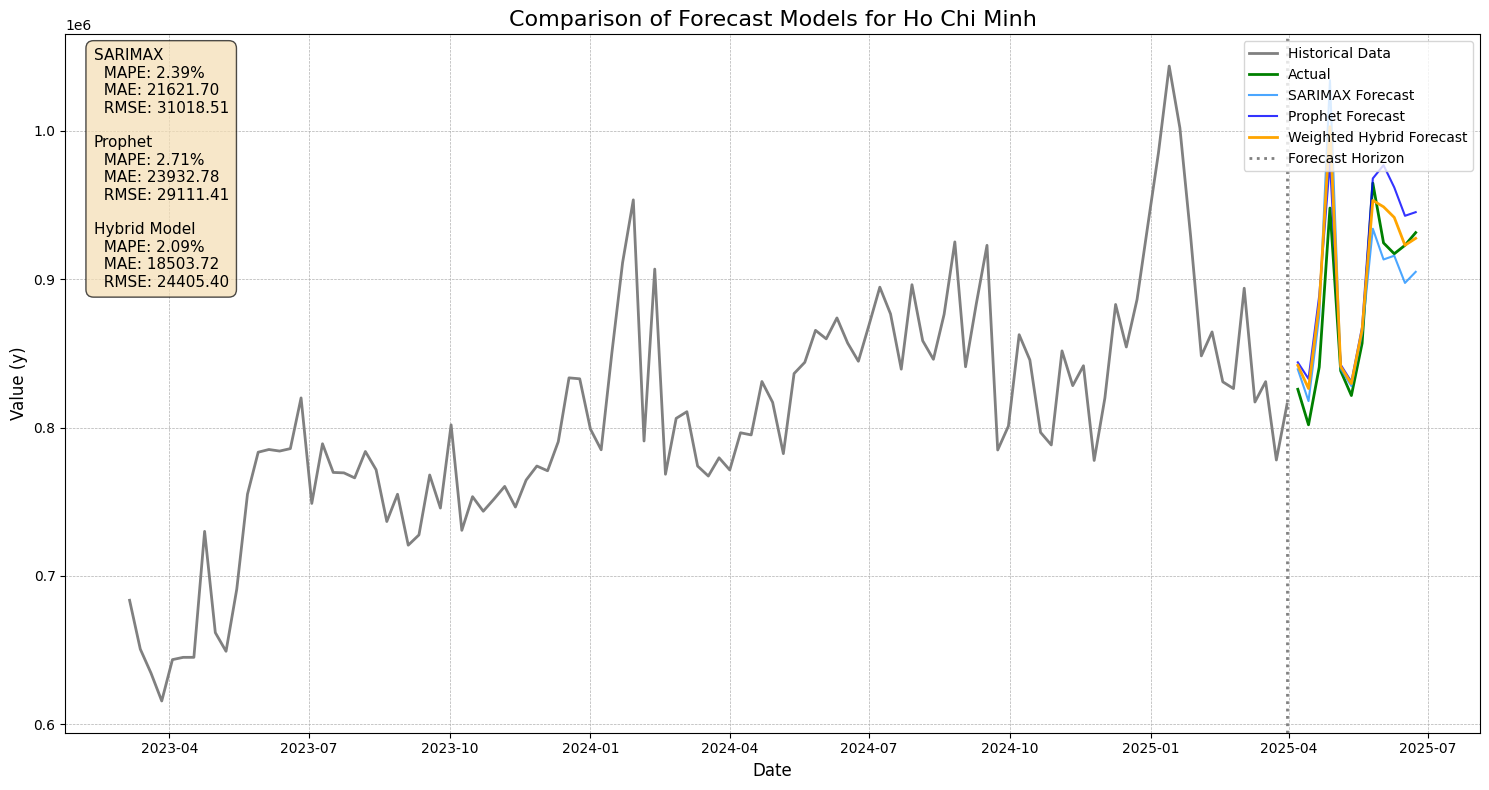

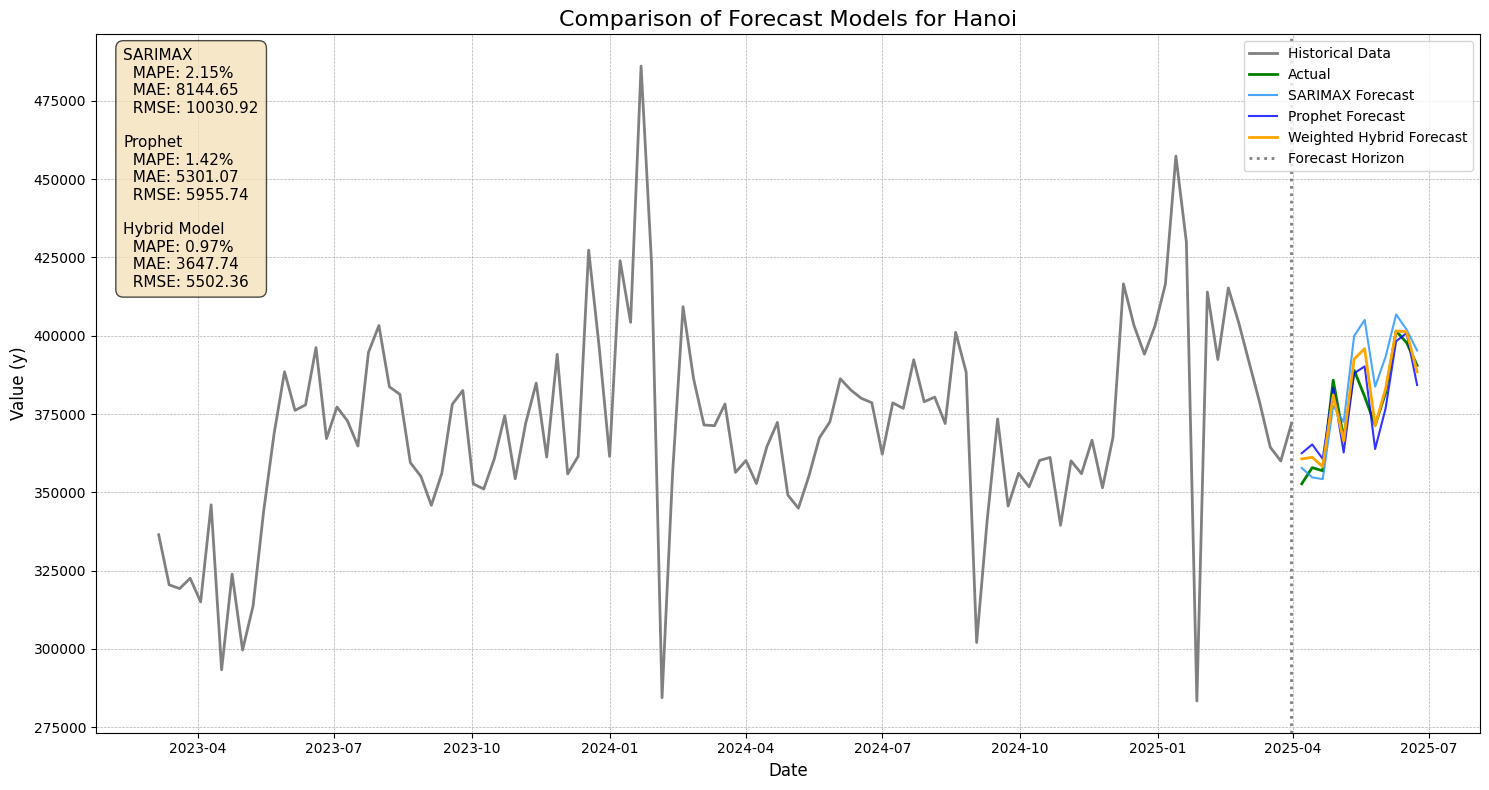

In [104]:
for city in city_name_list:

    # plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot historical data
    plt.plot(results[city]['train_data']['ds'], results[city]['train_data']['y'], color='grey', linewidth=2, label='Historical Data')
    plt.plot(results[city]['test_data']['ds'], results[city]['test_data']['y'], color='green', linewidth=2, label='Actual')

    # Plot the individual forecasts
    plt.plot(all_val_results_df[all_val_results_df['city'] == city]['ds'], all_val_results_df[all_val_results_df['city'] == city]['SARIMAX'], color='dodgerblue', alpha=0.8, label='SARIMAX Forecast')
    plt.plot(all_val_results_df[all_val_results_df['city'] == city]['ds'], all_val_results_df[all_val_results_df['city'] == city]['Prophet'], color='blue', alpha=0.8, label='Prophet Forecast')

    # Plot the final hybrid forecast
    plt.plot(all_val_results_df[all_val_results_df['city'] == city]['ds'], all_val_results_df[all_val_results_df['city'] == city]['Weighted Hybrid Model'], color='orange', linewidth=2, label='Weighted Hybrid Forecast')

    forecast_start_date = results[city]['train_data']['ds'].max()
    ax.axvline(x=forecast_start_date, color='grey', linestyle=':', linewidth=2, label='Forecast Horizon')

    # Add a text box with the performance metrics
    sarimax_row = df_metrics[(df_metrics['city'] == city) & (df_metrics['model'] == 'SARIMAX')].iloc[0]
    prophet_row = df_metrics[(df_metrics['city'] == city) & (df_metrics['model'] == 'Prophet')].iloc[0]
    hybrid_row = df_metrics[(df_metrics['city'] == city) & (df_metrics['model'] == 'Weighted Hybrid Model')].iloc[0]

    metrics_text = (
        f"SARIMAX\n"
        f"  MAPE: {sarimax_row['MAPE']:.2%}\n"
        f"  MAE: {sarimax_row['MAE']:.2f}\n"
        f"  RMSE: {sarimax_row['RMSE']:.2f}\n\n"
        f"Prophet\n"
        f"  MAPE: {prophet_row['MAPE']:.2%}\n"
        f"  MAE: {prophet_row['MAE']:.2f}\n"
        f"  RMSE: {prophet_row['RMSE']:.2f}\n\n"
        f"Hybrid Model\n"
        f"  MAPE: {hybrid_row['MAPE']:.2%}\n"
        f"  MAE: {hybrid_row['MAE']:.2f}\n"
        f"  RMSE: {hybrid_row['RMSE']:.2f}"
    )

    ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))

    # Formatting
    ax.set_title(f'Comparison of Forecast Models for {city}', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Value (y)', fontsize=12)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

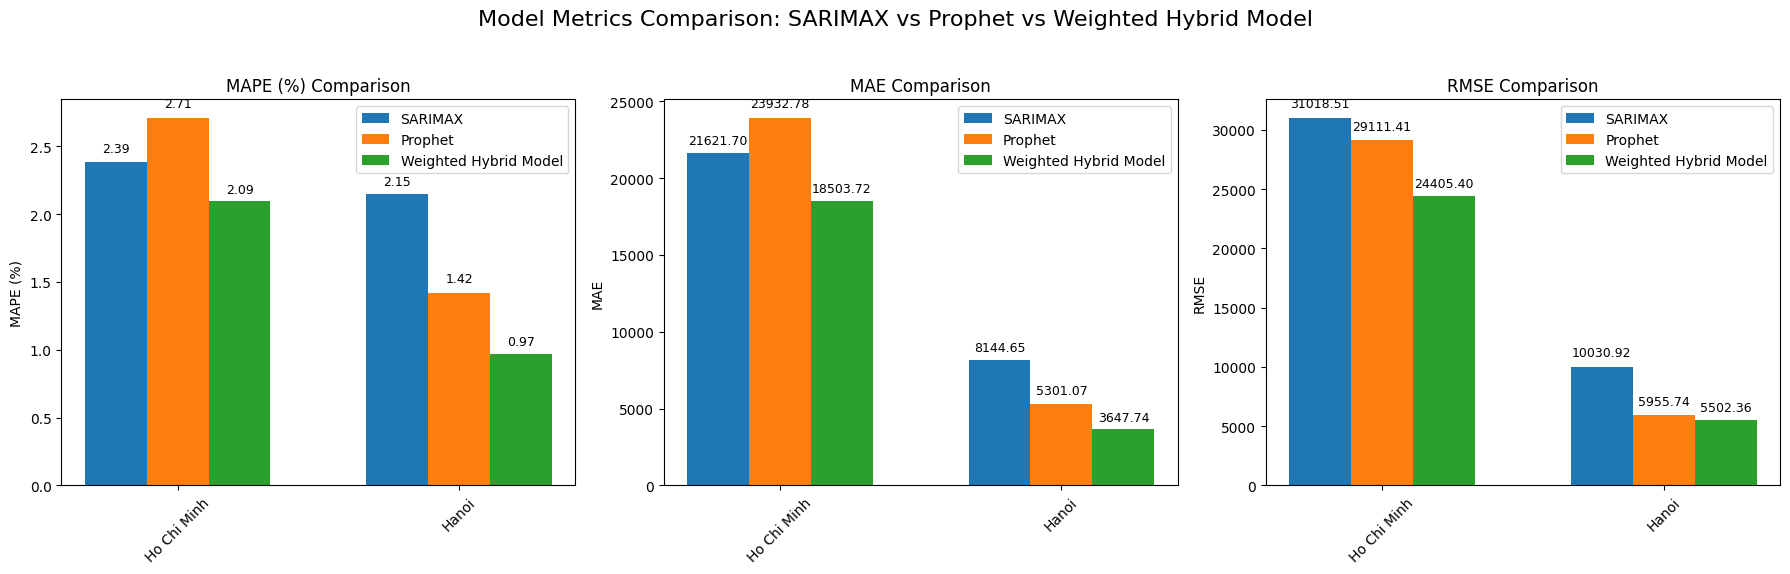

In [108]:
models = ['SARIMAX', 'Prophet', 'Weighted Hybrid Model']
cities = df_metrics['city'].unique()

metrics = ['MAPE', 'MAE', 'RMSE']
metric_labels = ['MAPE (%)', 'MAE', 'RMSE']

x = np.arange(len(cities))  # the label locations
width = 0.22  # the width of the bars

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    for i, model in enumerate(models):
        values = []
        for city in cities:
            val = df_metrics[(df_metrics['city'] == city) & (df_metrics['model'] == model)][metric].values
            if metric == 'MAPE':
                val = val * 100  # convert to percent
            values.append(val[0] if len(val) > 0 else np.nan)
        bars = ax.bar(x + i*width - width, values, width, label=model)
        # Show value on top of each bar
        for bar, value in zip(bars, values):
            if not np.isnan(value):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + (max(values) * 0.02 if max(values) > 0 else 0.02),
                    f'{value:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=9
                )
    ax.set_xticks(x)
    ax.set_xticklabels(cities, rotation=45)
    ax.set_title(f'{metric_labels[idx]} Comparison')
    ax.set_ylabel(metric_labels[idx])
    ax.legend()

plt.suptitle('Model Metrics Comparison: SARIMAX vs Prophet vs Weighted Hybrid Model', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()